# Sentinel-2 Autoencoder

## Download the EuroSAT dataset


[EuroSAT dataset](https://github.com/phelber/EuroSAT)
![](https://raw.githubusercontent.com/phelber/EuroSAT/master/eurosat_overview_small.jpg)


Download the dataset

In [1]:
import requests

url =  'http://madm.dfki.de/files/sentinel/EuroSAT.zip'
r = requests.get(url, allow_redirects=True)
open('EuroSAT.zip', 'wb').write(r.content)

94280567

Unzip the dataset

In [ ]:
!unzip '/content/EuroSAT.zip'

Rename the folder

In [3]:
!mv '/content/2750' '/content/EuroSAT'

Count images in the dataset

In [4]:
import glob

paths = glob.glob('/content/EuroSAT/*/*')
print('Number of images {}/27000'.format(len(paths)))

Number of images 27000/27000


## Image Data Generator 

In [109]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
import cv2
import numpy as np

batch_size = 16
root_dir = '/content/EuroSAT'
crop_size = 64
upscale_factor = 2
input_size = crop_size // upscale_factor

train_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="training",
    color_mode="rgb",
    seed=1337,
    label_mode=None,
)

valid_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="validation",
    color_mode="rgb",
    seed=1337,
    label_mode=None,
)

Found 27000 files belonging to 1 classes.
Using 21600 files for training.
Found 27000 files belonging to 1 classes.
Using 5400 files for validation.


In [110]:
import tensorflow as tf

# Use TF Ops to process.
def process_input(input, input_size, crop_size, upscale_factor):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)

    y = tf.image.resize(y, [input_size, input_size], method="nearest")
    y = tf.image.resize(y, [crop_size, crop_size], method="nearest")

    return y

def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return y

def scaling(input_image):
    input_image = input_image / 255.0
    return input_image

# Scale from (0, 255) to (0, 1)
train_ds = train_ds.map(scaling)
valid_ds = valid_ds.map(scaling)

train_ds = train_ds.map(
    lambda x: (process_input(x, input_size, crop_size, upscale_factor), process_target(x))
)
train_ds = train_ds.prefetch(buffer_size=32)

valid_ds = valid_ds.map(
    lambda x: (process_input(x, input_size, crop_size, upscale_factor), process_target(x))
)
valid_ds = valid_ds.prefetch(buffer_size=32)

Generate some exaples

In [107]:
x,y = next(iter(train_ds))
print('x shape {}'.format(x.shape))
print('y shape {}'.format(y.shape))

x shape (16, 64, 64, 1)
y shape (16, 64, 64, 1)


Plot some examples

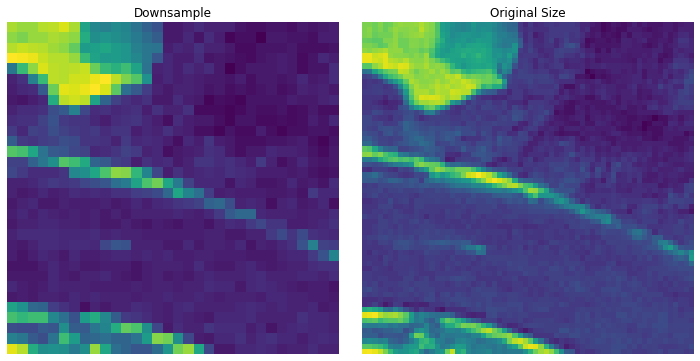

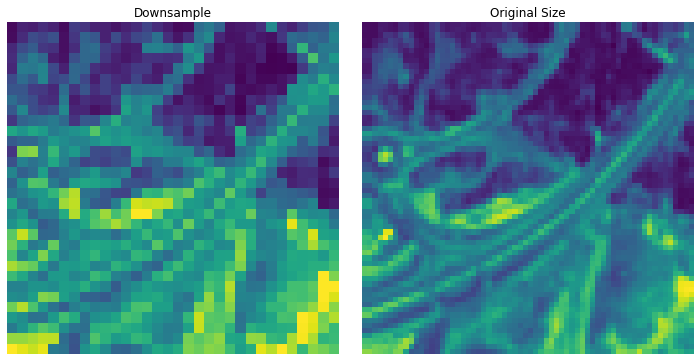

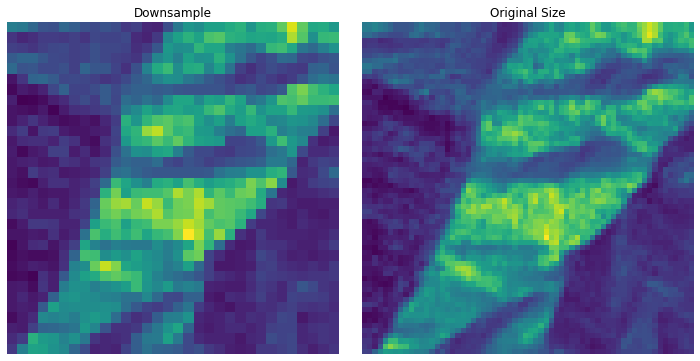

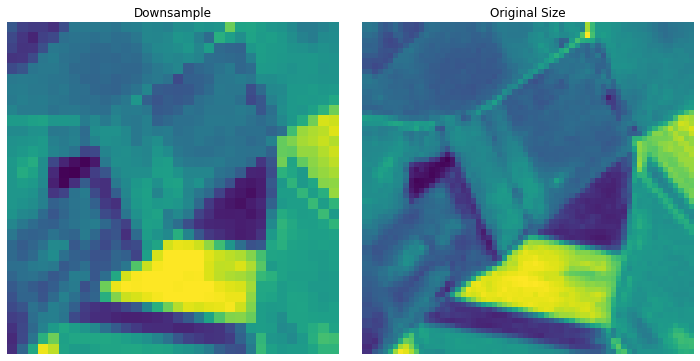

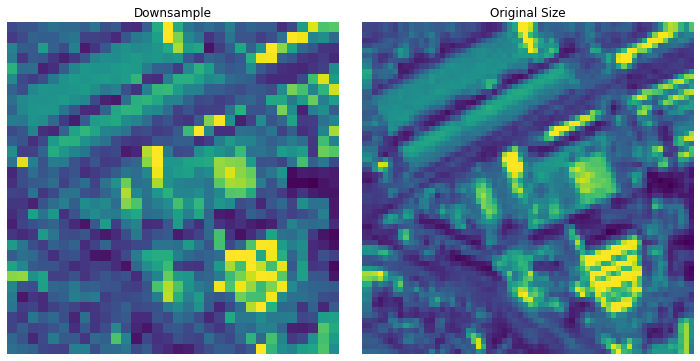

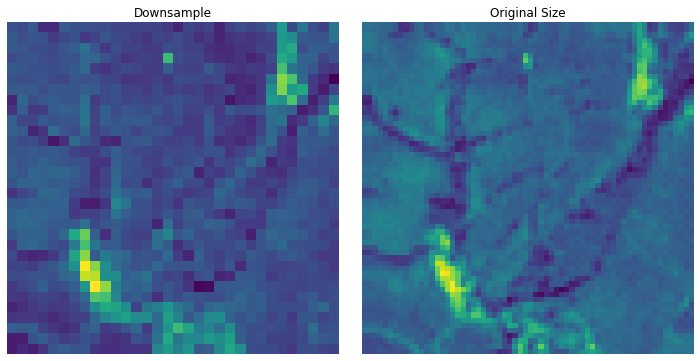

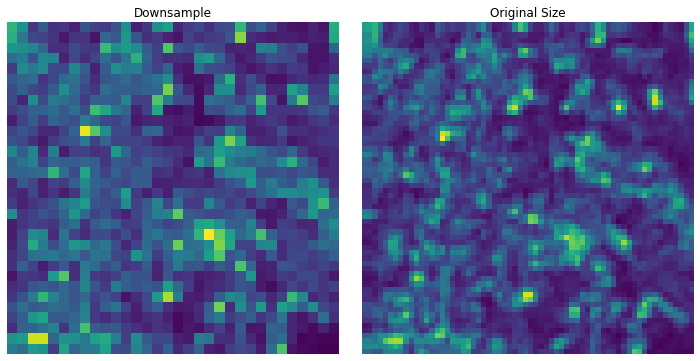

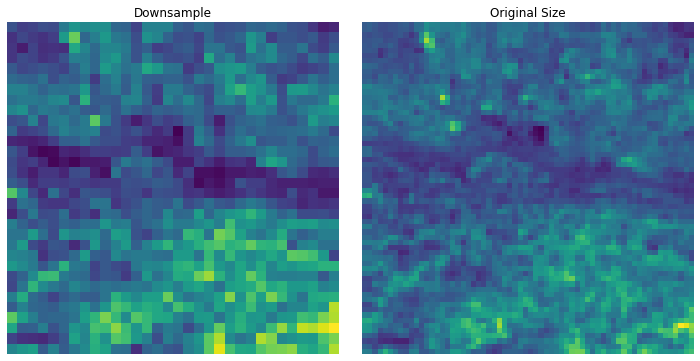

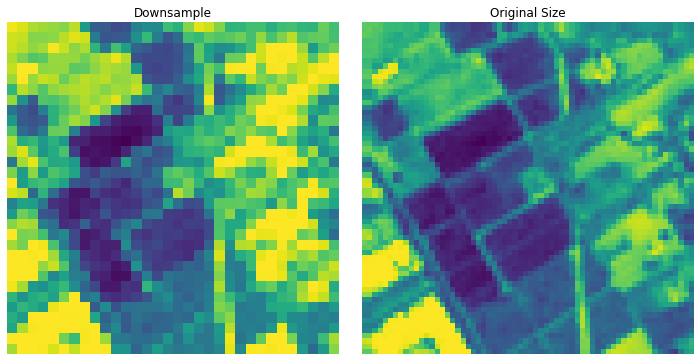

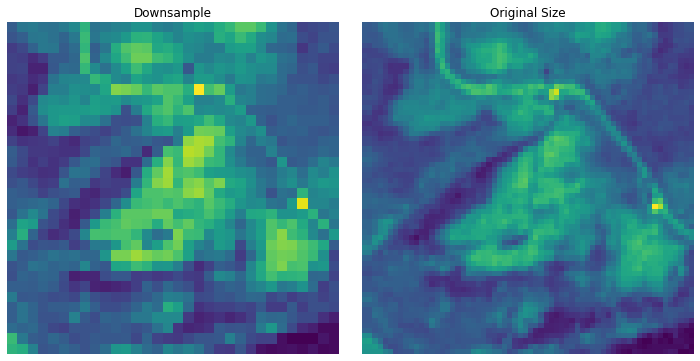

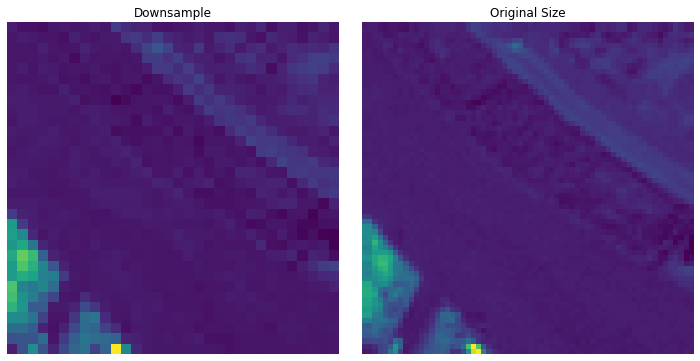

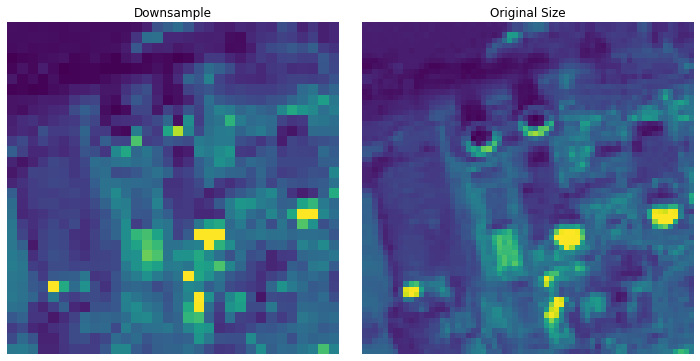

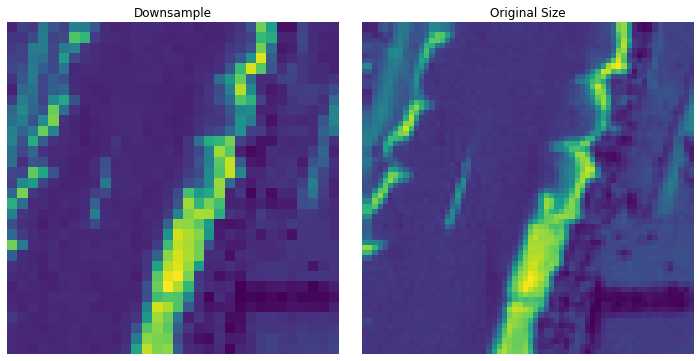

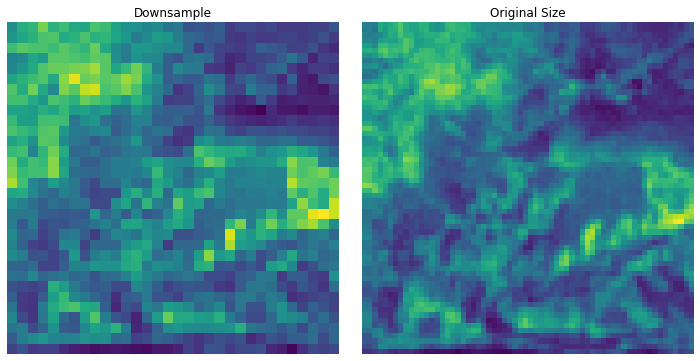

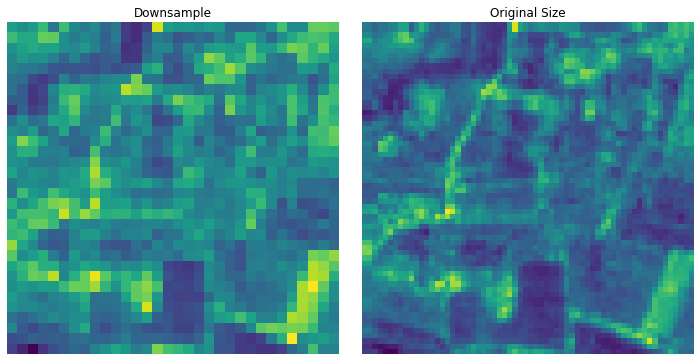

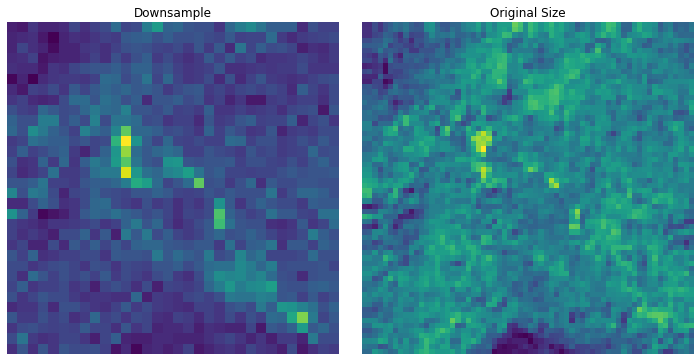

In [112]:
import matplotlib.pyplot as plt
import numpy as np


for i in range(batch_size):

  fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5))
  axes[0].imshow(x[i,:,:,0].numpy())
  axes[0].axis(False)
  axes[0].set_title('Downsample')

  axes[1].imshow(y[i,:,:,0].numpy())
  axes[1].axis(False)
  axes[1].set_title('Original Size')
  
  fig.tight_layout()
  plt.show()
  plt.close()


## Define the Autoencoder


In [80]:
from re import X
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, UpSampling2D


model = None
input_img = Input(shape=(64, 64, 1)) 

x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
x = Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)

x = Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = UpSampling2D(size=(2, 2))(x)
x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = UpSampling2D(size=(2, 2))(x)
x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = UpSampling2D(size=(2, 2))(x)

x = Conv2D(filters=1, kernel_size=(3, 3), activation='sigmoid', padding='same')(x)

model = Model(input_img, x)

Compile the model

In [81]:
from tensorflow.keras.optimizers import Adam, SGD

model.compile(loss='mse', optimizer=Adam(), metrics=['mae'])

Print model configuration

In [82]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 64, 64, 64)        640       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_25 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 16, 16, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 16, 16, 256)       2951

## Train the autoencoder

In [83]:
history = model.fit(
    train_ds,
    steps_per_epoch = len(train_ds.enumerate()),
    validation_data = valid_ds,
    validation_steps = len(valid_ds.enumerate()),
    epochs = 30
)

Epoch 1/30
1350/1350 [==============================] - 46s 33ms/step - loss: 0.0030 - mae: 0.0327 - val_loss: 0.0017 - val_mae: 0.0253
Epoch 2/30
1350/1350 [==============================] - 44s 33ms/step - loss: 0.0015 - mae: 0.0236 - val_loss: 0.0017 - val_mae: 0.0287
Epoch 3/30
1350/1350 [==============================] - 45s 33ms/step - loss: 0.0014 - mae: 0.0222 - val_loss: 0.0013 - val_mae: 0.0215
Epoch 4/30
1350/1350 [==============================] - 44s 33ms/step - loss: 0.0012 - mae: 0.0204 - val_loss: 0.0012 - val_mae: 0.0203
Epoch 5/30
1350/1350 [==============================] - 44s 33ms/step - loss: 0.0011 - mae: 0.0201 - val_loss: 0.0010 - val_mae: 0.0183
Epoch 6/30
1350/1350 [==============================] - 44s 33ms/step - loss: 0.0011 - mae: 0.0192 - val_loss: 9.8748e-04 - val_mae: 0.0180
Epoch 7/30
1350/1350 [==============================] - 44s 33ms/step - loss: 0.0010 - mae: 0.0190 - val_loss: 0.0011 - val_mae: 0.0200
Epoch 8/30
1350/1350 [======================

Plot training history

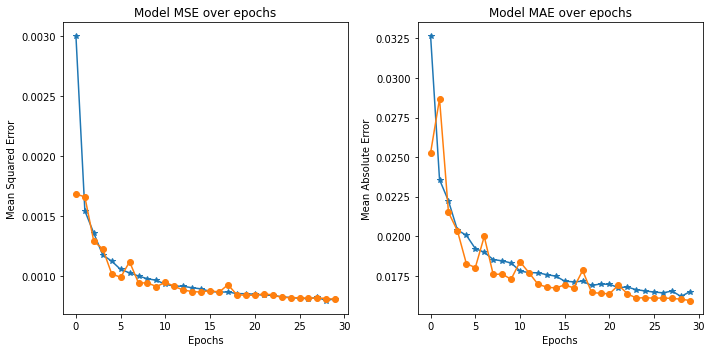

In [86]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5))

axes[0].plot(history.history['loss'], '-*', label = 'Training')
axes[0].plot(history.history['val_loss'], '-o', label = 'Validtion')
axes[0].set_ylabel('Mean Squared Error')
axes[0].set_xlabel('Epochs')
axes[0].set_title('Model MSE over epochs')

axes[1].plot(history.history['mae'], '-*', label = 'Training')
axes[1].plot(history.history['val_mae'], '-o', label = 'Validtion')
axes[1].set_ylabel('Mean Absolute Error')
axes[1].set_xlabel('Epochs')
axes[1].set_title('Model MAE over epochs')

fig.tight_layout()
plt.show()

## Evaluate Results

In [89]:
x, y = next(iter(valid_ds))
y_pred = model.predict(x)

	 --------------------------- Batch 0 ---------------------------


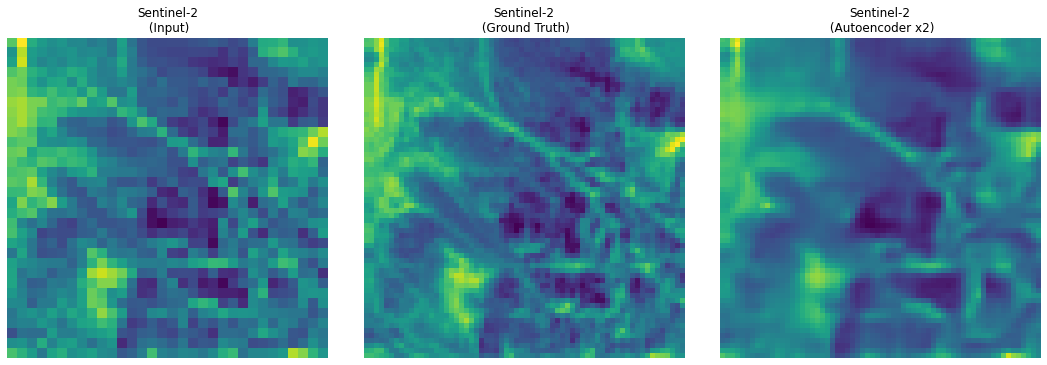

	 --------------------------- Batch 1 ---------------------------


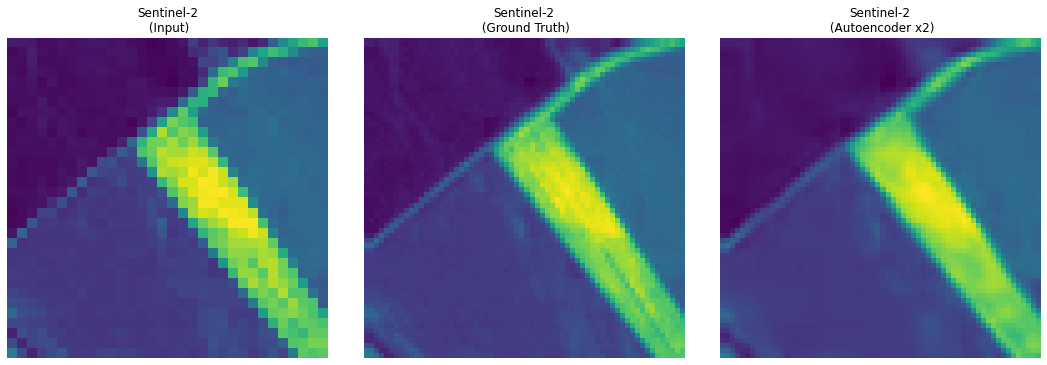

	 --------------------------- Batch 2 ---------------------------


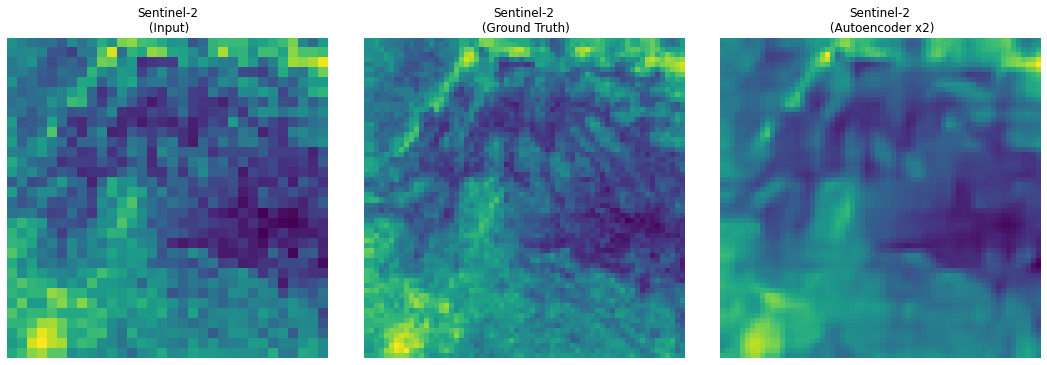

	 --------------------------- Batch 3 ---------------------------


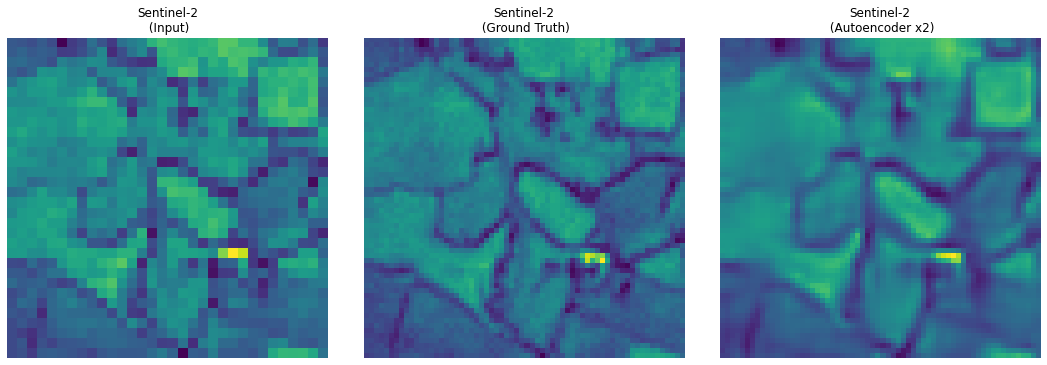

	 --------------------------- Batch 4 ---------------------------


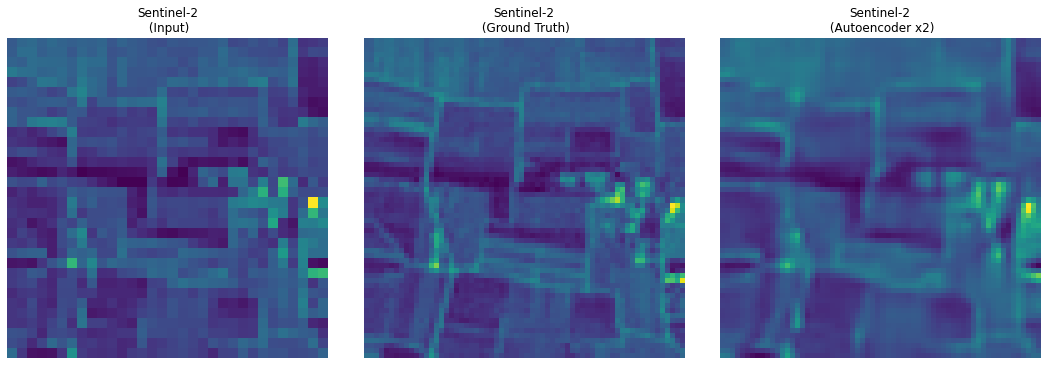

	 --------------------------- Batch 5 ---------------------------


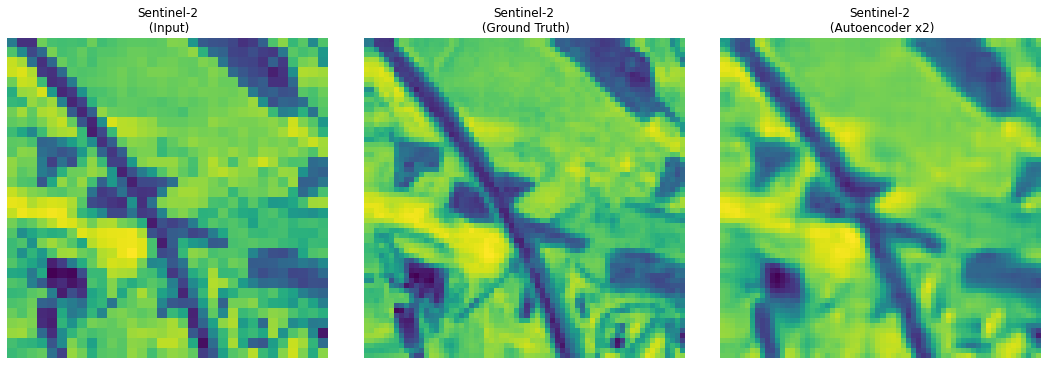

	 --------------------------- Batch 6 ---------------------------


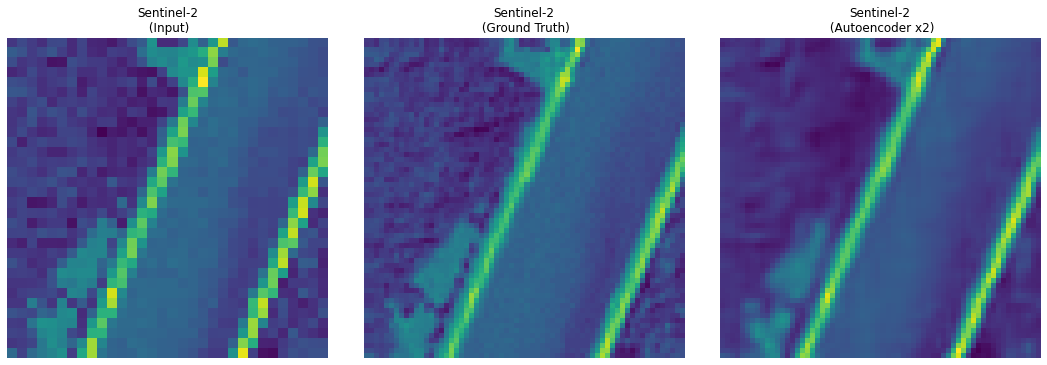

	 --------------------------- Batch 7 ---------------------------


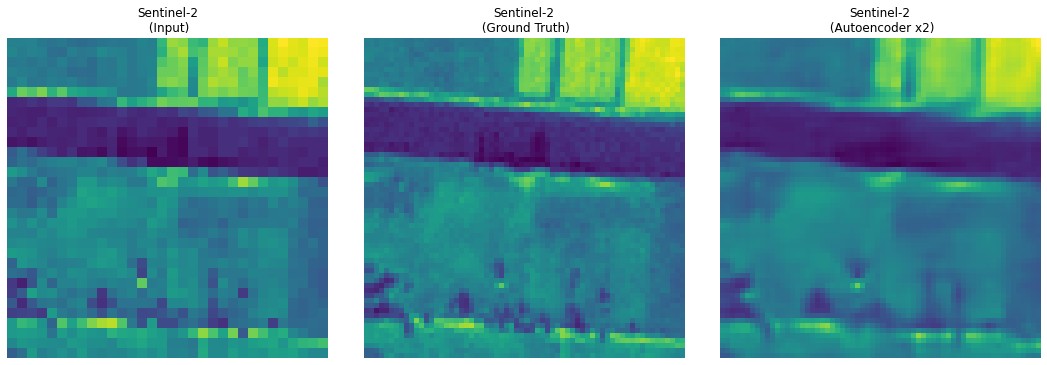

	 --------------------------- Batch 8 ---------------------------


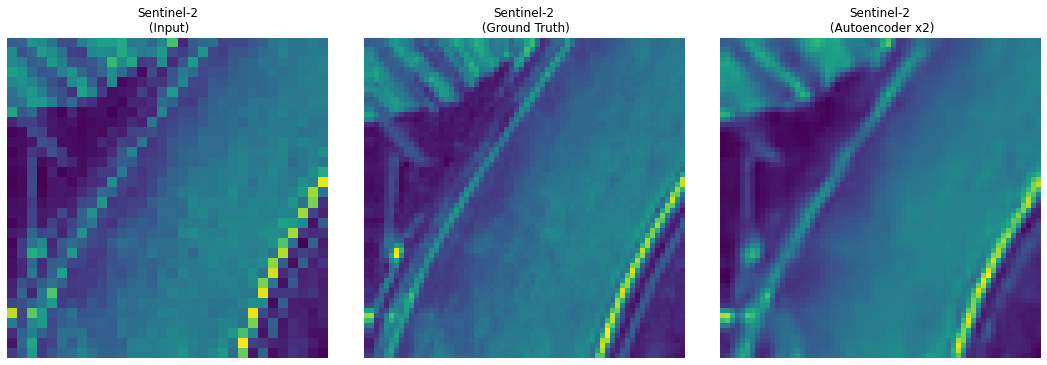

	 --------------------------- Batch 9 ---------------------------


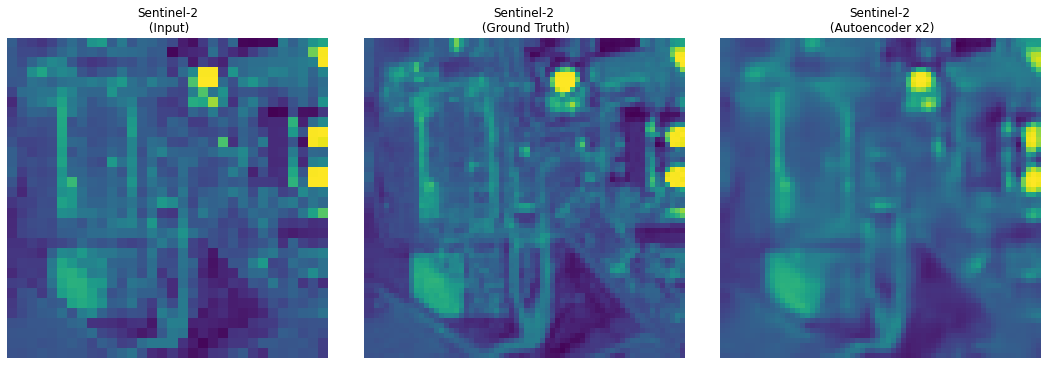

	 --------------------------- Batch 10 ---------------------------


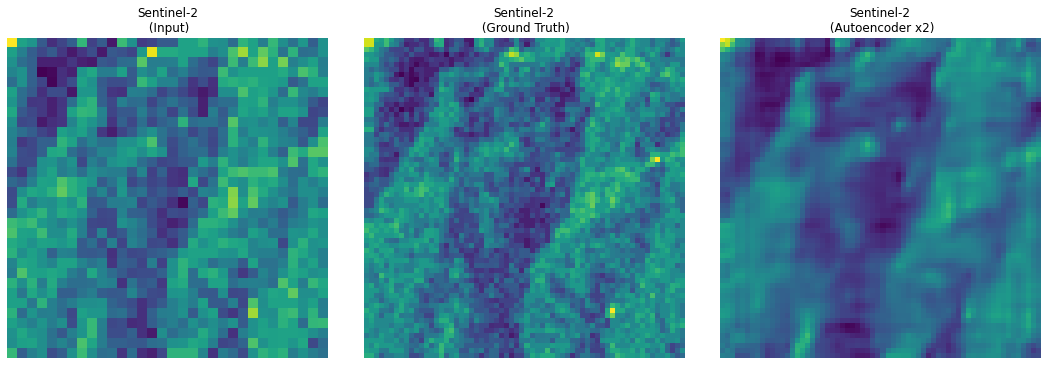

	 --------------------------- Batch 11 ---------------------------


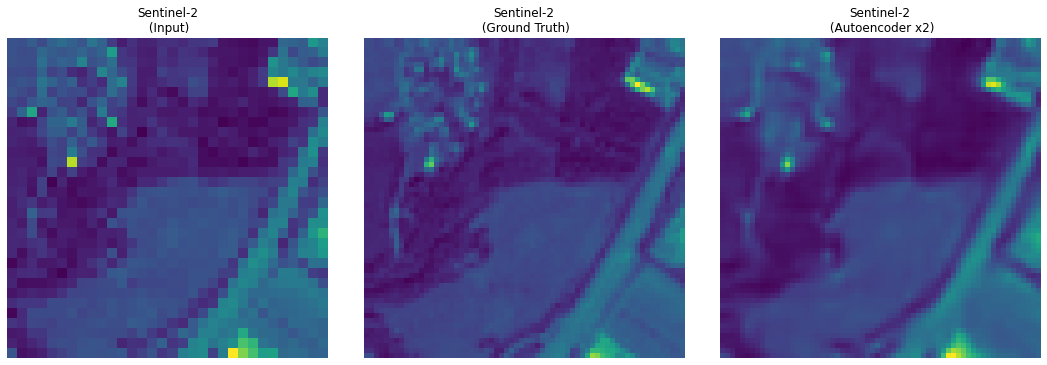

	 --------------------------- Batch 12 ---------------------------


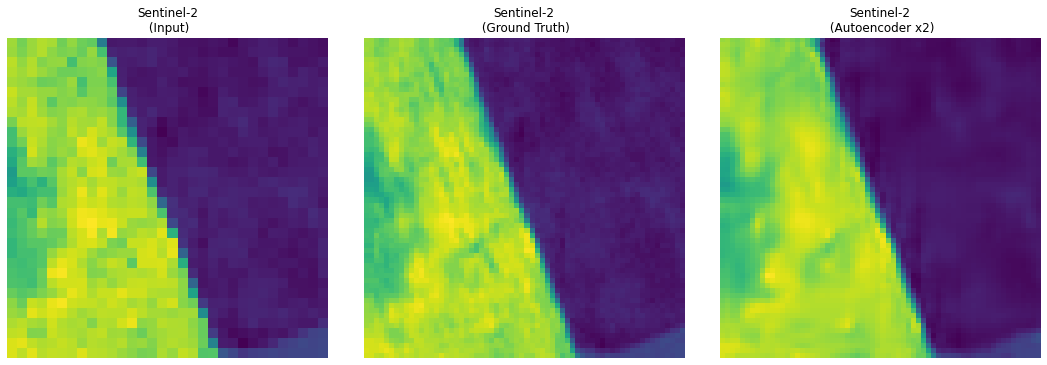

	 --------------------------- Batch 13 ---------------------------


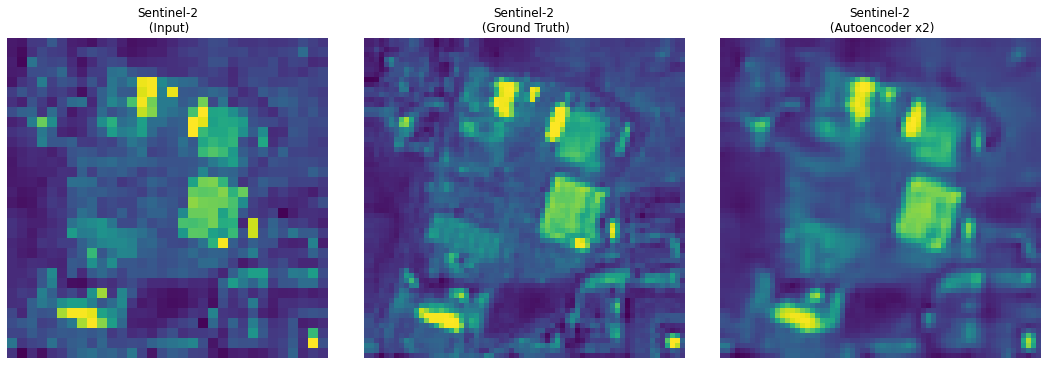

	 --------------------------- Batch 14 ---------------------------


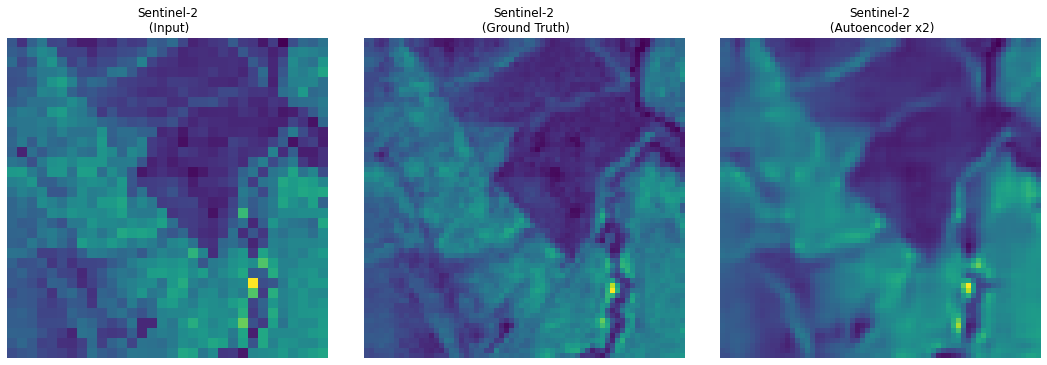

	 --------------------------- Batch 15 ---------------------------


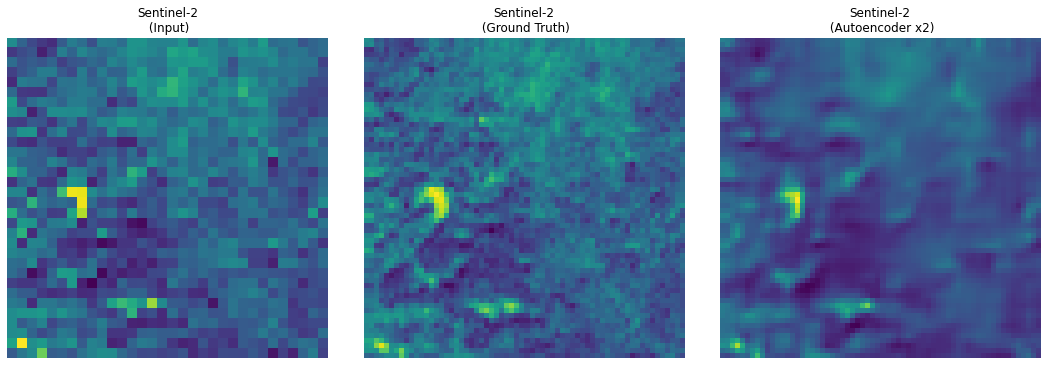

In [91]:
for i in range(batch_size):
  print('\t --------------------------- Batch {} ---------------------------'.format(i))

  fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15,5))
  axes[0].imshow(x[i,:,:,0])
  axes[0].axis(False)
  axes[0].set_title('Sentinel-2\n (Input)')

  axes[1].imshow(y[i,:,:,0])
  axes[1].axis(False)
  axes[1].set_title('Sentinel-2\n (Ground Truth)')

  axes[2].imshow(y_pred[i,:,:,0 ])
  axes[2].axis(False)
  axes[2].set_title('Sentinel-2\n (Autoencoder x2)')

  fig.tight_layout()
  plt.show()
  plt.close()